In [1]:
import requests
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

from dotenv import load_dotenv
import os

# move key to a secrets json file
load_dotenv()
API_KEY = os.getenv("API_KEY")
API_URL = os.getenv("API_URL")

# fetch data from API
locations = {
    "SCA": "California",
    "SCO": "Colorado",
    "SFL": "Florida",
    "SNY": "New York",
    "STX": "Texas"
}

params = {
    "api_key": API_KEY,
    "frequency": "monthly",
    "data[]": "value",
    "start": "2010",
    "end": "2026",
}
rows = []

for location_code, state_name in locations.items():
    params["facets[duoarea][0]"] = location_code
    response = requests.get(API_URL, params=params)
    response.raise_for_status()
    data = response.json()
    monthly_prices = data.get("response", {}).get("data", [])
    

    # Sort monthly data and append to DataFrame
    sorted_prices = sorted(monthly_prices, key=lambda x: x["period"])
    for entry in sorted_prices:
        rows.append({
            "state_code": location_code,
            "state_name": state_name,
            "period": entry["period"],
            "value": entry["value"]
        })


monthly_df = pd.DataFrame(rows)

# Convert 'value' to numeric and 'period' to datetime
monthly_df["value"] = pd.to_numeric(monthly_df["value"], errors="coerce")
monthly_df["period"] = pd.to_datetime(monthly_df["period"])

%store monthly_df
monthly_df['period'].unique()



Stored 'monthly_df' (DataFrame)


<DatetimeArray>
['2010-01-01 00:00:00', '2010-02-01 00:00:00', '2010-03-01 00:00:00',
 '2010-04-01 00:00:00', '2010-05-01 00:00:00', '2010-06-01 00:00:00',
 '2010-07-01 00:00:00', '2010-08-01 00:00:00', '2010-09-01 00:00:00',
 '2010-10-01 00:00:00',
 ...
 '2024-06-01 00:00:00', '2024-07-01 00:00:00', '2024-08-01 00:00:00',
 '2024-09-01 00:00:00', '2024-10-01 00:00:00', '2024-11-01 00:00:00',
 '2024-12-01 00:00:00', '2025-01-01 00:00:00', '2025-02-01 00:00:00',
 '2025-03-01 00:00:00']
Length: 183, dtype: datetime64[ns]

In [2]:
energy_data = pd.read_csv('US_Crude_data_v1.csv')
# Convert 'Dates' in energy_data to datetime
energy_data['Dates'] = pd.to_datetime(energy_data['Dates'], format='%m/%d/%Y')

# Extract year-month for merging
energy_data['period'] = energy_data['Dates'].dt.to_period('M').dt.to_timestamp()

energy_data['Dates'].unique()

<DatetimeArray>
['1990-01-01 00:00:00', '1990-02-01 00:00:00', '1990-03-01 00:00:00',
 '1990-04-01 00:00:00', '1990-05-01 00:00:00', '1990-06-01 00:00:00',
 '1990-07-01 00:00:00', '1990-08-01 00:00:00', '1990-09-01 00:00:00',
 '1990-10-01 00:00:00',
 ...
 '2025-03-01 00:00:00', '2025-04-01 00:00:00', '2025-05-01 00:00:00',
 '2025-06-01 00:00:00', '2025-07-01 00:00:00', '2025-08-01 00:00:00',
 '2025-09-01 00:00:00', '2025-10-01 00:00:00', '2025-11-01 00:00:00',
 '2025-12-01 00:00:00']
Length: 432, dtype: datetime64[ns]

In [3]:
merged_df = pd.merge(
    monthly_df,
    energy_data.drop(columns=["Dates"]),  # Drop original 'Dates' to avoid duplicates
    on="period",
    how="left"  # Keeps all months from monthly_df, fills missing energy_data with NaN
)

merged_df = merged_df.sort_values('period')
%store merged_df
merged_df.head()


Stored 'merged_df' (DataFrame)


,state_code,state_name,period,value,Crude Oil Production,Dry Natural Gas Production,Coal Production,Total Energy Production (qBtu),Liquid Fuels Consumption,Natural Gas Consumption,...,Natural Gas ($/mBtu),Coal ($/mBtu),Real Gross Domestic Product (Trillions),RGDP Percent change YOY (%),GDP Implicit Price Deflator,GDP IPD Percent change YOY (%),Real Disposable Personal Income,RDPI Percent change YOY (%),Manufacturing Production Index,MPI Percent change YOY (%)
0,SCA,California,2010-01-01,3.017,5.4,56.04,86,4.94,18.65,90.64,...,5.83,2.23,16.583,1.7,89.0,0.5,12286,-0.6,89.6,2.4
6957,STX,Texas,2010-01-01,2.699,5.4,56.04,86,4.94,18.65,90.64,...,5.83,2.23,16.583,1.7,89.0,0.5,12286,-0.6,89.6,2.4
6958,STX,Texas,2010-01-01,2.622,5.4,56.04,86,4.94,18.65,90.64,...,5.83,2.23,16.583,1.7,89.0,0.5,12286,-0.6,89.6,2.4
6959,STX,Texas,2010-01-01,2.819,5.4,56.04,86,4.94,18.65,90.64,...,5.83,2.23,16.583,1.7,89.0,0.5,12286,-0.6,89.6,2.4
6960,STX,Texas,2010-01-01,2.553,5.4,56.04,86,4.94,18.65,90.64,...,5.83,2.23,16.583,1.7,89.0,0.5,12286,-0.6,89.6,2.4


In [4]:
merged_df_encoded = pd.get_dummies(merged_df, columns= ['state_name'])


In [5]:
merged_df_encoded.columns

Index(['state_code', 'period', 'value', 'Crude Oil Production',
       'Dry Natural Gas Production', 'Coal Production',
       'Total Energy Production (qBtu)', 'Liquid Fuels Consumption',
       'Natural Gas Consumption', 'Coal Consumption',
       'Electricity Consumption', 'Renewables Consumption',
       'Total Energy Consumption (qBtu)', 'Crude Oil ($/barrel)',
       'Natural Gas ($/mBtu) ', 'Coal ($/mBtu)',
       'Real Gross Domestic Product (Trillions)',
       'RGDP Percent change YOY (%)', 'GDP Implicit Price Deflator',
       'GDP IPD Percent change YOY (%)', 'Real Disposable Personal Income',
       'RDPI Percent change YOY (%)', 'Manufacturing Production Index',
       'MPI Percent change YOY (%)', 'state_name_California',
       'state_name_Colorado', 'state_name_Florida', 'state_name_New York',
       'state_name_Texas'],
      dtype='object')

In [6]:
merged_df_encoded.isnull().sum()
merged_df_clean = merged_df_encoded.dropna()
merged_df_clean.isnull().sum()
merged_df_clean.count()
%store merged_df_clean

Stored 'merged_df_clean' (DataFrame)


In [7]:
#Getting X and y
y = merged_df_clean.value

features = ['Crude Oil Production',
            'Liquid Fuels Consumption',
            'Electricity Consumption',
            'Crude Oil ($/barrel)',
            'Real Gross Domestic Product (Trillions)',
            'RGDP Percent change YOY (%)',
            'Real Disposable Personal Income',
            'RDPI Percent change YOY (%)',
            'Manufacturing Production Index',
            'MPI Percent change YOY (%)',
            'GDP Implicit Price Deflator',
            'GDP IPD Percent change YOY (%)',
            'state_name_California',
            'state_name_Colorado', 
            'state_name_Florida', 
            'state_name_New York',
            'state_name_Texas']
            
X = merged_df_clean[features]

X.head()

,Crude Oil Production,Liquid Fuels Consumption,Electricity Consumption,Crude Oil ($/barrel),Real Gross Domestic Product (Trillions),RGDP Percent change YOY (%),Real Disposable Personal Income,RDPI Percent change YOY (%),Manufacturing Production Index,MPI Percent change YOY (%),GDP Implicit Price Deflator,GDP IPD Percent change YOY (%),state_name_California,state_name_Colorado,state_name_Florida,state_name_New York,state_name_Texas
0,5.4,18.65,11.06,78.33,16.583,1.7,12286,-0.6,89.6,2.4,89.0,0.5,True,False,False,False,False
6957,5.4,18.65,11.06,78.33,16.583,1.7,12286,-0.6,89.6,2.4,89.0,0.5,False,False,False,False,True
6958,5.4,18.65,11.06,78.33,16.583,1.7,12286,-0.6,89.6,2.4,89.0,0.5,False,False,False,False,True
6959,5.4,18.65,11.06,78.33,16.583,1.7,12286,-0.6,89.6,2.4,89.0,0.5,False,False,False,False,True
6960,5.4,18.65,11.06,78.33,16.583,1.7,12286,-0.6,89.6,2.4,89.0,0.5,False,False,False,False,True


In [8]:
y.isnull().sum()

np.int64(0)

In [9]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(6861, 17)
(2288, 17)
(6861,)
(2288,)


In [10]:
# Function to train and evaluate the model
def train_model(X_train, y_train, X_test, y_test):
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    
    # Evaluation
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"R2 Score: {r2:.2f}")
    
    # Plot predictions vs actual
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.values, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.title("Actual vs Predicted Petroleum Prices")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.show()


# Train and evaluate the model
print("Training model...")

param_grid = {
    'n_estimators': [200, 250, 300],
    'max_depth': [20, 30, 40], 
    'min_samples_split': [10, 15, 20]
}

rf = RandomForestRegressor(random_state = 0)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
print("Best params:", grid_search.best_params_)
best_rf = grid_search.best_estimator_

#best_rf = RandomForestRegressor(random_state = 0, n_estimators = 200, max_depth = 20, min_samples_split = 10)
#best_rf.fit(X_train, y_train)

Training model...


Best params: {'max_depth': 30, 'min_samples_split': 20, 'n_estimators': 200}


In [11]:
y_pred = best_rf.predict(X_test)
# MSE and R2
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R2 Score: {r2:.2f}")

#this is also R2
test_score = best_rf.score(X_test, y_test)
print(test_score)

Mean Squared Error: 0.05
Mean Absolute Error: 0.18
R2 Score: 0.92
0.9190968688328915


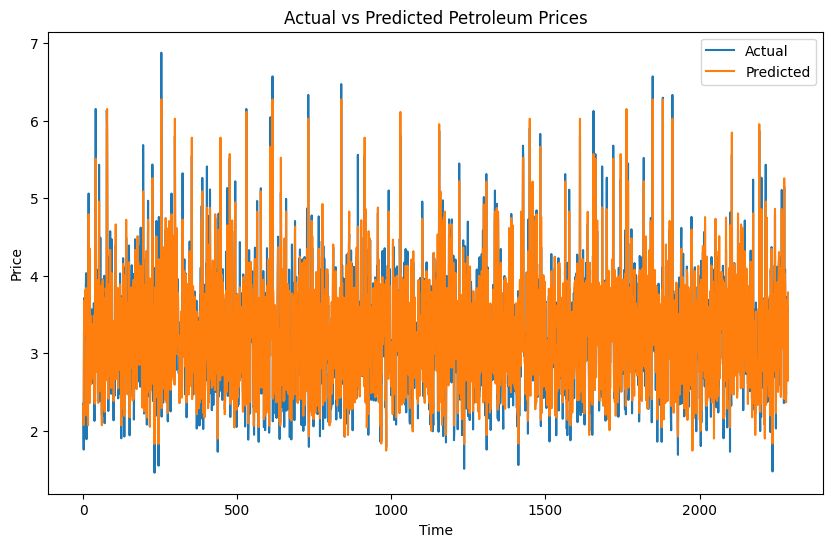

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title("Actual vs Predicted Petroleum Prices")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

In [13]:
row_to_show = 5
data_for_prediction =  X_train.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

best_rf.predict(data_for_prediction_array)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


array([4.00137061])

In [14]:
import shap

#Initialize SHAP explainer
explainer = shap.TreeExplainer(best_rf)

#Makes choosing rows simpler
row_idx = 1000

#Compute SHAP values for a single prediction
shap_values = explainer.shap_values(X_test.iloc[row_idx:row_idx+1])  # Input must be 2D (1 sample). Also gives the predicted price

shap.initjs()
shap.force_plot(
    explainer.expected_value,  # Base value (average prediction)
    shap_values[0],            # SHAP values for the sample
    X_test.iloc[row_idx],            # Feature values on the plot
    feature_names=X_test.columns
)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


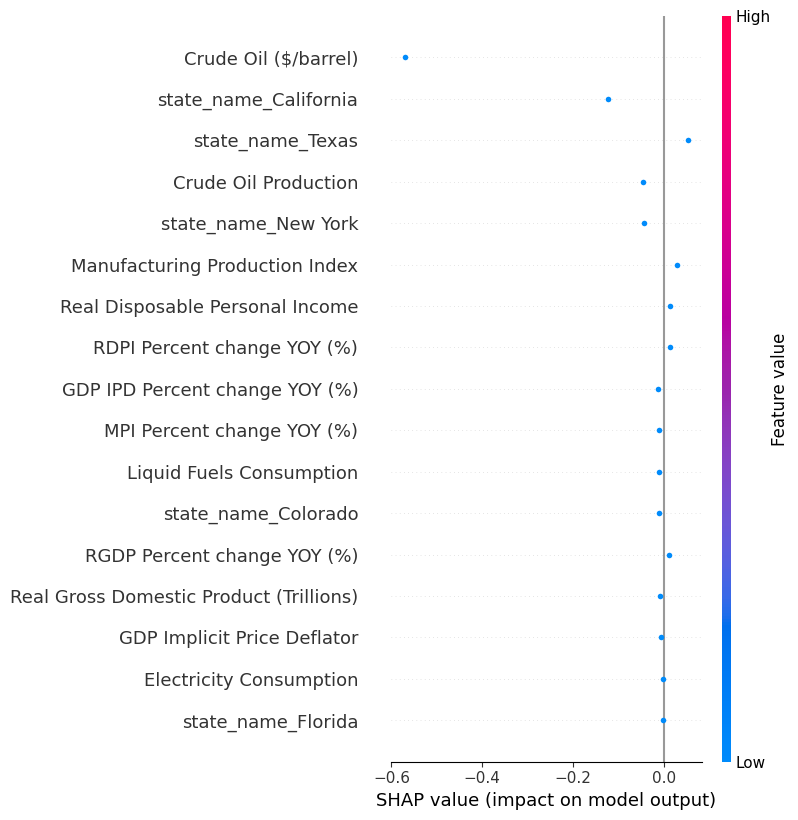

In [17]:
global_shap_values = explainer.shap_values(X_test)
#shap.summary_plot(global_shap_values, X_test, feature_names=X_test.columns, alpha = 0.5)

shap.summary_plot(shap_values, X_test.iloc[0:1], feature_names=X_test.columns) #For metrics on a single row ran

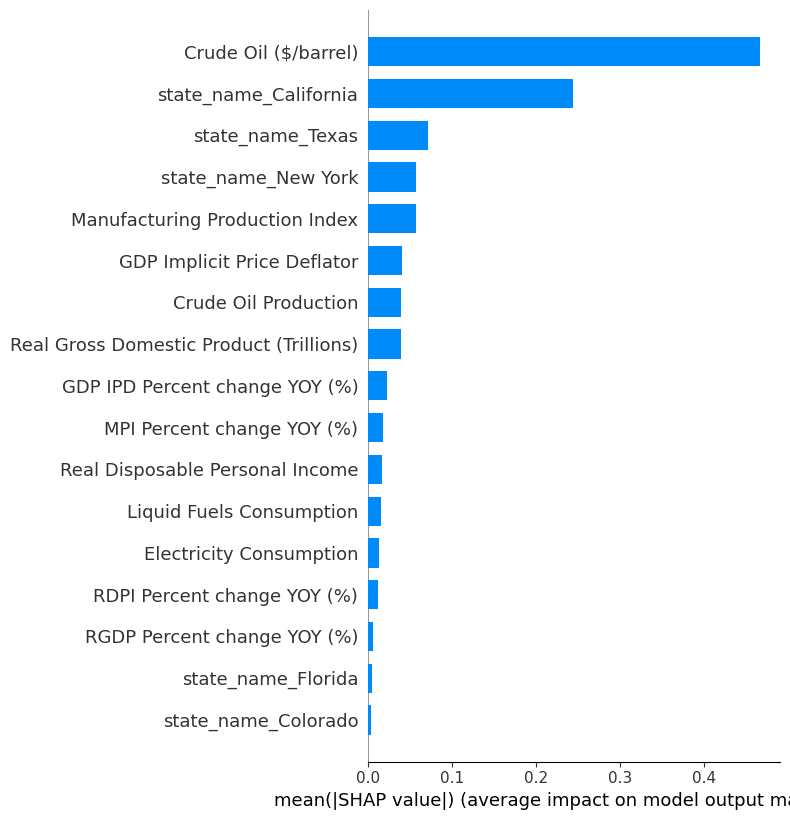

In [16]:
shap.summary_plot(global_shap_values, X_test, plot_type="bar", feature_names=X_train.columns)

# shap.summary_plot(global_shap_values, X_test.iloc[0:1], plot_type="bar", feature_names=X_train.columns)  for a single test ran